# Red tipo mapa de Kohonen
---
Implementación de red tipo mapa de Kohonen para procesar caracteres escritos a mano para reconocer caracteres (clasificación con LVQ) y asociar caracteres parciales con caracteres completos (memoria asociativa).

## Análisis del dataset a utilizar
El dataset provisto por la cátedra es un archivo formato CSV, una tabla, donde cada fila es una lista con el valor de los pixeles de una imágen de un caracter. Estas imágenes son de 28 x 28 pixeles, es decir, la lista es de 784 números de 0 a 255.

EL dataset brindado da las imágenes sin etiqueta, por lo que no se posee información de qué caracter corresponde a cada imágen. Es por esto que el método de resolución del problema es una red neuronal no supervisada.

In [0]:
import csv
import numpy as np

In [0]:
collection = []
with open('A_Z Handwritten Data.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for i, row in enumerate(csvReader):
        collection.append(np.array(row, dtype=float))
        if (i > 10):
          break

In [58]:
with open('A_Z Handwritten Data.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    row_count = sum(1 for row in csvReader)
print(row_count)

206853


Para poder observar los datos ingresados previo a implementar el algoritmo se reconstruyen una muestra de 5 imágenes del dataset:

In [0]:
from matplotlib import pyplot as plt

In [0]:
data = []

number = np.ndarray((28, 28))

for img in collection:
    iter = 0
    for i in range(0, 28):
        for j in range(0, 28):
            number[i, j] = (img[iter])
            iter += 1
    number = np.zeros((28, 28))
    data.append(number)

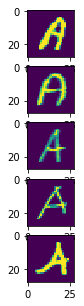

In [20]:
f, axes = plt.subplots(5, 1, figsize=(5, 5))
for i, ax in enumerate(axes):
  ax.imshow(data[i])

Con el fin de preparar los datos de entrada al algoritmo, se normalizan los valores de la imágen, pasando de 0 a 255 a valores entre 0 y 1.

In [0]:
data_analys = []

for img in collection:
    img_as_float = img / 255
    data_analys.append(img_as_float)

In [27]:
data_analys[0].shape

(785,)

## Modelo de la Red Neuronal

In [0]:
x = data_analys[0]

map_kohonen = np.zeros((200, 200)) # Mapa de neuronas

W = np.zeros((map_kohonen.shape[0], map_kohonen.shape[1], x.shape[0]))        

In [37]:
W.shape
W[0, 0, :].shape

(785,)

### Ritmo de aprendizaje $\alpha(t)$
Se seleccionó como ritmo de aprendizaje un función decreciente exponencial de la forma:

$\alpha(t)=\alpha_{0}\left(\frac{\alpha_{f}}{\alpha_{0}}\right)^{\frac{t}{t_{\alpha}}}$

In [0]:
def ritmo_aprendizaje(t, t_alfa=100, alfa_0=0.7, alfa_f=0.01):
    alfa = alfa_0 * (alfa_f / alfa_0)**(t / t_alfa)
    return alfa

### Función de vecindad $h(|\bar{i}-\bar{g}|, t)$
Para comenzar, se eligió una función simple como es la escalón.

In [0]:
def vecindad(i, g, t, R=radio_vecindad):
    aux = np.sqrt((i[0] - g[0])**2 + (i[1] - g[1])**2)
    if (aux > R(t)):
        return 0
    else:
        return 1

Donde el radio de vecindad $R(t)$ desciende linealmente:

In [0]:
def radio_vecindad(t, t_r=100, R_0=100, R_f=1):
    R = R_0 + (R_f - R_0) * t / t_r
    return R

### Métricas de similitud
Se seleccionó como métrica de similitud la distancia euclídea:

$d^{2}(\bar{w_{ij}}, \bar{x}) = \displaystyle\sum_{k=1}^{n} (w_{ij} - x_{k})^{2}$

In [0]:
def d_euclidean(x, w):
    sum = 0
    for i in range(x.shape[0]):
        sum += (x[i] - w[i])**2
    return sum

Solo para calcular la similitud de un $w_{ijk}$ con una entrada $x$, se debe recorrer todo el vector, es decir, k iteraciones (en este caso 785 iteraciones).

### Reglas de aprendizaje para la métrica de similitud usada
La regla de aprendizaje para la distancia euclídea es de la forma:

$\bar{w_{i}}(t+1) = \bar{w_{i}}(t) + \alpha(t) \cdot h(|\bar{i} - \bar{g}|, t) \cdot (x_{k}(t) - w_{ijk}(t))$

In [0]:
def update_w(w, x, i, g, t, ritmo_aprendizaje, vecindad):
    w_new = w + ritmo_aprendizaje(t) * vecindad(i, g, t) * (x - w)
    return w_new

## Análisis de las diferentes etapas de entrenamiento de la red neuronal

### Inicialización de pesos sinápticos
Se inicializan los pesos sinápticos con números aleatorios pequeños tomados de una distribución Gaussiana con $\mu=0$ y $\sigma=1$:

In [0]:
from numpy.random import normal

mu = 0
sigma = 1

for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        W[i, j, :] = abs(0.01 * normal(mu, sigma, W.shape[2]))

### Obtención de neurona ganadora

La neurona ganadora $\bar{g}$ cumple:

$\bar{g} = \text{arg}\quad\displaystyle\text{min}_{ij}\left[ d(\bar{w_{ij}}, \bar{x})\right]$

In [0]:
from math import inf

minim = inf

for i in range(map_kohonen.shape[0]):
    for j in range(map_kohonen.shape[1]):
        map_kohonen[i, j] = d_euclidean(x, W[i, j, :])
        if (map_kohonen[i, j] < minim):
            minim = map_kohonen[i, j]
            g = [i, j]

In [42]:
g

[168, 164]

### Actualización de pesos sinápticos

In [0]:
t = 0
for x in data_analys:
    minim = inf

    for i in range(map_kohonen.shape[0]):
        for j in range(map_kohonen.shape[1]):
            map_kohonen[i, j] = d_euclidean(x, W[i, j, :])
            if (map_kohonen[i, j] < minim):
                minim = map_kohonen[i, j]
                g = [i, j]
    
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i, j, :] = update_w(W[i, j, :], x, [i, j], g, t, ritmo_aprendizaje, vecindad)
    
    t += 1

## Entrenamiento de la red neuronal

In [0]:
collection = []
with open('A_Z Handwritten Data.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for i, row in enumerate(csvReader):
        collection.append(np.array(row, dtype=float))

In [0]:
data_analys = []

for img in collection:
    img_as_float = img / 255
    data_analys.append(img_as_float)

In [0]:
from random import shuffle

shuffle(data_analys)

In [0]:
t = 0
for x in data_analys:
    minim = inf

    for i in range(map_kohonen.shape[0]):
        for j in range(map_kohonen.shape[1]):
            map_kohonen[i, j] = d_euclidean(x, W[i, j, :])
            if (map_kohonen[i, j] < minim):
                minim = map_kohonen[i, j]
                g = [i, j]
    
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i, j, :] = update_w(W[i, j, :], x, [i, j], g, t, ritmo_aprendizaje, vecindad)
    
    t += 1